In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib

E:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df = pd.read_csv('data/cmc_train.csv', header = None)
data=df.values[1:]
data=data.astype(float)
X_train=data[:,0:9]
y_train=data[:,9]
y_train=y_train.astype(int)

df = pd.read_csv('data/cmc_test.csv', header = None)
data=df.values[1:]
data=data.astype(float)
X_test=data[:,0:9]
y_test=data[:,9]
y_test=y_test.astype(int)

In [3]:
# 模型训练，使用GBDT算法
gbr = GradientBoostingClassifier(n_estimators=30000, max_depth=2, min_samples_split=2, learning_rate=0.01)
gbr.fit(X_train, y_train.ravel())
joblib.dump(gbr, 'train_model_result4.m')   # 保存模型

['train_model_result4.m']

In [4]:
y_gbr = gbr.predict(X_train)
y_gbr1 = gbr.predict(X_test)
acc_train = gbr.score(X_train, y_train)
acc_test = gbr.score(X_test, y_test)
print(acc_train)
print(acc_test)

0.7791479820627802
0.4751131221719457


In [5]:
# AdaBoostClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200, learning_rate=0.8)

In [6]:
bdt.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                              

In [7]:
y_bdt = bdt.predict(X_train)
y_bdt = bdt.predict(X_test)
acc_train = bdt.score(X_train, y_train)
acc_test = bdt.score(X_test, y_test)
print(acc_train)
print(acc_test)

0.554932735426009
0.5113122171945701


In [8]:
#  xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
model = XGBClassifier(learning_rate=0.01,max_depth=10)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=false)

[0]	validation_0-mlogloss:1.09572
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.09295
[2]	validation_0-mlogloss:1.09022
[3]	validation_0-mlogloss:1.08751
[4]	validation_0-mlogloss:1.08495
[5]	validation_0-mlogloss:1.08237
[6]	validation_0-mlogloss:1.07981
[7]	validation_0-mlogloss:1.07738
[8]	validation_0-mlogloss:1.075
[9]	validation_0-mlogloss:1.07262
[10]	validation_0-mlogloss:1.07028
[11]	validation_0-mlogloss:1.06797
[12]	validation_0-mlogloss:1.06568
[13]	validation_0-mlogloss:1.06341
[14]	validation_0-mlogloss:1.06119
[15]	validation_0-mlogloss:1.05913
[16]	validation_0-mlogloss:1.05704
[17]	validation_0-mlogloss:1.05494
[18]	validation_0-mlogloss:1.05278
[19]	validation_0-mlogloss:1.05084
[20]	validation_0-mlogloss:1.04885
[21]	validation_0-mlogloss:1.04689
[22]	validation_0-mlogloss:1.04501
[23]	validation_0-mlogloss:1.04313
[24]	validation_0-mlogloss:1.0413
[25]	validation_0-mlogloss:1.0395
[26]	validation_0-mlogloss:1.03753


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

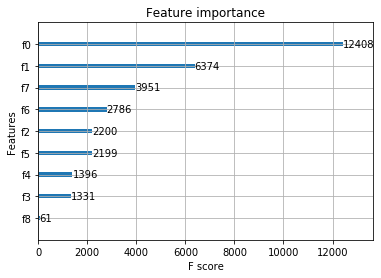

In [9]:
plot_importance(model)
pyplot.show()

In [10]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [11]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 50.23%


In [12]:
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
esb_clf2=VotingClassifier(estimators=[
    ('Xgboost',model),
    ('AdaBoost',bdt),
    ('GBDT',gbr)],
    weights=[1,1,1],
    voting='hard')

In [13]:
esb_clf2.fit(X_train,y_train)
esb_pred2=esb_clf2.predict(X_test)

In [14]:
from sklearn.metrics import classification_report as report
print('ensemble-hard:\n',report(y_test,esb_pred2))
print(y_test)
print(esb_pred2)

ensemble-hard:
               precision    recall  f1-score   support

           1       0.57      0.60      0.58        84
           2       0.46      0.45      0.46        55
           3       0.46      0.45      0.46        82

    accuracy                           0.51       221
   macro avg       0.50      0.50      0.50       221
weighted avg       0.51      0.51      0.51       221

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[1 2 2 1 3 2 1 1 1 1 1 1 1 1 3 1 1 2 3 3 1 2 1 3 3 1 2 2 1 1 1 2 3 1 3 1 1
 3 3 1 1 2 1 1 1 3 3 1 1 1 1 3 3 3 1 3 1 1 1 1 3 1 1 3 1 1 2 1 3 1 1 1 1 1
 3 1

In [15]:
df = pd.read_csv('data/cmc_train.csv', header = None)
data=df.values[1:]
X_train=data[:,[0,3,7,6]]
y_train=data[:,9]
y_train=y_train.astype(int)

df = pd.read_csv('data/cmc_test.csv', header = None)
data=df.values[1:]
data=data.astype(float)
X_test=data[:,[0,3,7,6]]
y_test=data[:,9]
y_test=y_test.astype(int)

In [16]:
# 模型训练，使用GBDT算法
gbr = GradientBoostingClassifier(n_estimators=30000, max_depth=2, min_samples_split=2, learning_rate=0.01)
gbr.fit(X_train, y_train.ravel())
joblib.dump(gbr, 'train_model_result4.m')   # 保存模型

['train_model_result4.m']

In [17]:
y_gbr = gbr.predict(X_train)
y_gbr1 = gbr.predict(X_test)
acc_train = gbr.score(X_train, y_train)
acc_test = gbr.score(X_test, y_test)
print(acc_train)
print(acc_test)
print(y_gbr1)
print(y_test)

0.6121076233183856
0.38009049773755654
[3 2 2 1 2 2 2 1 3 3 1 1 3 2 3 1 3 3 1 2 2 2 1 3 1 1 3 2 2 1 1 2 2 1 3 2 3
 1 3 1 3 2 2 3 3 2 3 1 1 2 3 3 1 3 1 3 3 2 1 3 3 3 3 3 3 2 2 1 3 1 1 1 1 1
 3 3 3 3 1 3 1 3 2 3 3 1 2 1 2 2 1 3 3 3 1 1 3 2 2 1 3 1 1 1 2 2 1 3 1 3 3
 2 2 1 1 1 1 3 2 3 3 2 2 3 2 1 3 1 2 3 3 2 2 2 3 1 3 1 2 1 3 3 1 3 1 1 3 1
 3 1 2 3 2 3 2 2 3 3 3 3 3 3 3 1 2 1 3 2 3 1 2 1 1 3 1 2 3 3 1 3 2 3 3 3 3
 3 3 3 3 1 2 3 3 3 3 1 2 2 1 3 3 2 3 1 2 2 3 1 3 2 3 2 2 2 1 1 2 3 2 1 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [18]:
# AdaBoostClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20, min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200, learning_rate=0.1)

In [19]:
bdt.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                              

In [20]:
y_bdt = bdt.predict(X_train)
y_bdt = bdt.predict(X_test)
acc_train = bdt.score(X_train, y_train)
acc_test = bdt.score(X_test, y_test)
print(acc_train)
print(acc_test)
print(y_gbr1)
print(y_test)

0.49887892376681614
0.42081447963800905
[3 2 2 1 2 2 2 1 3 3 1 1 3 2 3 1 3 3 1 2 2 2 1 3 1 1 3 2 2 1 1 2 2 1 3 2 3
 1 3 1 3 2 2 3 3 2 3 1 1 2 3 3 1 3 1 3 3 2 1 3 3 3 3 3 3 2 2 1 3 1 1 1 1 1
 3 3 3 3 1 3 1 3 2 3 3 1 2 1 2 2 1 3 3 3 1 1 3 2 2 1 3 1 1 1 2 2 1 3 1 3 3
 2 2 1 1 1 1 3 2 3 3 2 2 3 2 1 3 1 2 3 3 2 2 2 3 1 3 1 2 1 3 3 1 3 1 1 3 1
 3 1 2 3 2 3 2 2 3 3 3 3 3 3 3 1 2 1 3 2 3 1 2 1 1 3 1 2 3 3 1 3 2 3 3 3 3
 3 3 3 3 1 2 3 3 3 3 1 2 2 1 3 3 2 3 1 2 2 3 1 3 2 3 2 2 2 1 1 2 3 2 1 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [21]:
model = XGBClassifier(learning_rate=0.09,max_depth=10)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=True)

[0]	validation_0-mlogloss:1.08904
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:1.08147
[2]	validation_0-mlogloss:1.07576
[3]	validation_0-mlogloss:1.07237
[4]	validation_0-mlogloss:1.0698
[5]	validation_0-mlogloss:1.06747
[6]	validation_0-mlogloss:1.06589
[7]	validation_0-mlogloss:1.0649
[8]	validation_0-mlogloss:1.06438
[9]	validation_0-mlogloss:1.06412
[10]	validation_0-mlogloss:1.06509
[11]	validation_0-mlogloss:1.066
[12]	validation_0-mlogloss:1.06807
[13]	validation_0-mlogloss:1.07079
[14]	validation_0-mlogloss:1.07368
[15]	validation_0-mlogloss:1.07747
[16]	validation_0-mlogloss:1.08085
[17]	validation_0-mlogloss:1.08421
[18]	validation_0-mlogloss:1.08782
[19]	validation_0-mlogloss:1.0917
Stopping. Best iteration:
[9]	validation_0-mlogloss:1.06412



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.09, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 44.34%


In [24]:
rf_clf=RandomForestClassifier(
    n_estimators=21,
    criterion="gini",
    max_depth=4,
    random_state=0)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [25]:
rf_pred=rf_clf.predict(X_test)
print('rf:\n',report(y_test, rf_pred))
print(y_test)
print(rf_pred)

rf:
               precision    recall  f1-score   support

           1       0.50      0.33      0.40        84
           2       0.33      0.29      0.31        55
           3       0.44      0.63      0.52        82

    accuracy                           0.43       221
   macro avg       0.43      0.42      0.41       221
weighted avg       0.44      0.43      0.42       221

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[1 1 2 3 3 2 2 1 3 1 1 1 3 2 3 3 3 3 3 3 2 2 1 3 3 3 3 2 2 1 1 2 3 1 3 3 3
 1 3 1 1 2 3 3 3 3 3 1 1 3 3 3 1 3 1 1 3 2 2 3 1 3 3 3 2 1 3 1 3 1 1 1 2 1
 3 3 3 3 1 3 3 

In [26]:
esb_clf2=VotingClassifier(estimators=[
    ('Xgboost',model),
    ('AdaBoost',bdt),
    ('GBDT',gbr),
    ('RF',rf_clf)],
    weights=[1,0.4,1,0.4],
    voting='hard')

In [27]:
esb_clf2.fit(X_train,y_train)
esb_pred2=esb_clf2.predict(X_test)

In [28]:
from sklearn.metrics import classification_report as report
print('ensemble-hard:\n',report(y_test,esb_pred2))
print(y_test)
print(esb_pred2)

ensemble-hard:
               precision    recall  f1-score   support

           1       0.45      0.40      0.43        84
           2       0.36      0.35      0.35        55
           3       0.45      0.50      0.47        82

    accuracy                           0.43       221
   macro avg       0.42      0.42      0.42       221
weighted avg       0.42      0.43      0.42       221

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[3 1 2 3 2 2 2 1 3 1 1 1 3 2 3 1 3 3 1 3 1 2 1 3 3 1 3 1 2 1 1 2 2 1 3 3 3
 1 3 1 1 1 2 3 3 3 1 1 1 3 3 3 1 3 1 1 3 2 1 3 3 3 3 3 2 1 2 1 3 1 1 1 1 1
 3 3